## 3. Empirical Cumulative Outlier Detection (ECOD)

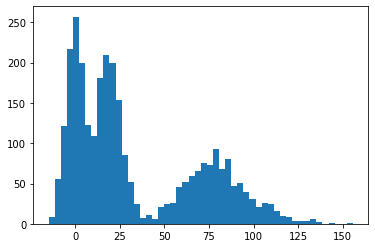

In [30]:
# Create a distribution that is the combination of three other distributions
from matplotlib import pyplot
from numpy.random import normal, gamma
from numpy import hstack
shape, scale = 10, 2.  
s1 = gamma(shape, scale, 1000)
s2 = gamma(shape * 2, scale * 2, 1000)
s3 = normal(loc=0, scale=5, size=1000)
sample = hstack((s1, s2, s3))
# plot the histogram
pyplot.hist(sample, bins=50)
pyplot.show()

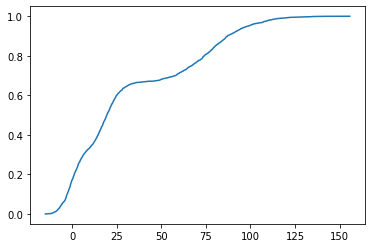

In [31]:
# fit a cdf
from statsmodels.distributions.empirical_distribution import ECDF
sample_ecdf = ECDF(sample)

# plot the cdf
pyplot.plot(sample_ecdf.x, sample_ecdf.y)
pyplot.show()

In [32]:
print('P(x<-20): %.4f' % sample_ecdf(-20))
print('P(x<-2): %.4f' % sample_ecdf(-2))
print('P(x<0): %.4f' % sample_ecdf(0))
print('P(x<25): %.4f' % sample_ecdf(25))
print('P(x<50): %.4f' % sample_ecdf(50))
print('P(x<75): %.4f' % sample_ecdf(75))
print('P(x<100): %.4f' % sample_ecdf(100))
print('P(x<125): %.4f' % sample_ecdf(125))
print('P(x<140): %.4f' % sample_ecdf(140))
print('P(x<150): %.4f' % sample_ecdf(150))

P(x<-20): 0.0000
P(x<-2): 0.1190
P(x<0): 0.1723
P(x<25): 0.6000
P(x<50): 0.6810
P(x<75): 0.8067
P(x<100): 0.9540
P(x<125): 0.9943
P(x<140): 0.9993
P(x<150): 0.9997


In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyod.utils.data import generate_data
contamination = 0.05 # percentage of outliers
n_train = 500       # number of training points
n_test = 500        # number of testing points
n_features = 6      # number of features
X_train, X_test, y_train, y_test = generate_data(
    n_train=n_train, 
    n_test=n_test, 
    n_features= n_features, 
    contamination=contamination, 
    random_state=123)

# Make the 2d numpy array a pandas dataframe for each manipulation 
X_train_pd = pd.DataFrame(X_train)
X_train_pd.head()

,0,1,2,3,4,5
0,2.396090,2.092611,2.073392,1.988262,1.953473,2.450997
1,1.631040,1.746182,1.898050,2.380148,1.967332,1.858916
2,1.824683,2.131412,2.028829,1.703454,2.502966,2.119108
3,2.106098,2.165173,2.340826,2.170109,1.749139,1.678661
4,1.829647,1.775596,1.829438,2.054768,1.577190,1.594549


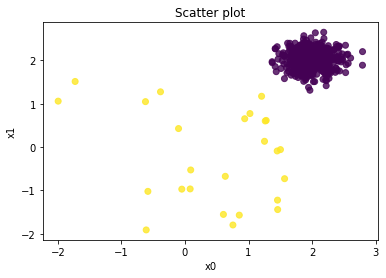

In [34]:
# Plot
plt.scatter(X_train_pd[0], X_train_pd[1], c=y_train, alpha=0.8)
plt.title('Scatter plot')
plt.xlabel('x0')
plt.ylabel('x1')
plt.show()

### Step 1: Build the model

In [51]:
from pyod.models.ecod import ECOD
ecod = ECOD() #contamination=0.05)
ecod.fit(X_train)

# Training data
y_train_scores = ecod.decision_function(X_train)
y_train_pred = ecod.predict(X_train)

# Test data
y_test_scores = ecod.decision_function(X_test)
y_test_pred = ecod.predict(X_test) # outlier labels (0 or 1)

def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic. 
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

print("The training data:", count_stat(y_train_pred))
print("The training data:", count_stat(y_test_pred))
# Threshold for the defined comtanimation rate
print("The threshold for the defined comtanimation rate:" , ecod.threshold_)

The training data: {0: 450, 1: 50}
The training data: {0: 444, 1: 56}
The threshold for the defined comtanimation rate: 12.75035460032711


In [52]:
np.where(y_train_scores>22)

(array([475, 477, 478, 479, 480, 483, 484, 486, 488, 489, 490, 492, 494,
        495, 496, 497, 498, 499]),)

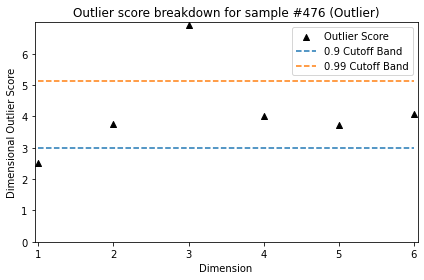

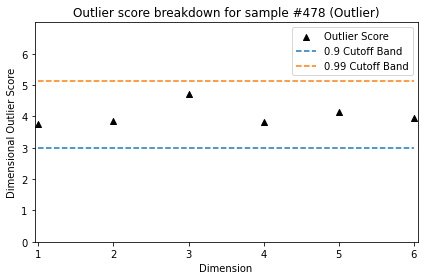

In [53]:
ecod.explain_outlier(475)
ecod.explain_outlier(477)

### Step 2: Determine the threshold

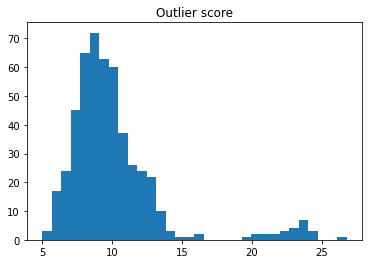

In [54]:
import matplotlib.pyplot as plt
plt.hist(y_train_scores, bins='auto') # arguments are passed to np.histogram
plt.title("Outlier score")
plt.show()

### Step 3: Descriptive statistics

In [61]:
threshold = 15 # Or other value from the above histogram

def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

descriptive_stat_threshold(X_train,y_train_scores, threshold)

,Group,Count,Count %,0,1,2,3,4,5,Anomaly_Score
0,Normal,472,94.4,2.00,2.01,2.00,1.99,2.01,1.98,9.36
1,Outlier,28,5.6,0.64,0.05,-0.14,0.01,0.18,0.18,22.12


In [62]:
descriptive_stat_threshold(X_test,y_test_scores, threshold)

,Group,Count,Count %,0,1,2,3,4,5,Anomaly_Score
0,Normal,468,93.6,2.02,2.01,2.01,1.99,2.01,2.00,9.40
1,Outlier,32,6.4,0.43,0.06,0.28,0.43,0.40,0.53,21.24


In [60]:
def confusion_matrix(actual,pred):
    Actual_pred = pd.DataFrame({'Actual': actual, 'Pred': pred})
    cm = pd.crosstab(Actual_pred['Actual'],Actual_pred['Pred'])
    return (cm)
confusion_matrix(y_train,y_train_pred)

Pred,0,1
Actual,,
0.0,450,25
1.0,0,25


### Two models: HBOS and ECOD

In [41]:
########
# HBOS #
########
from pyod.models.hbos import HBOS
n_bins = 50
hbos = HBOS(n_bins=n_bins, contamination=0.05)
hbos.fit(X_train)
y_train_hbos_pred = hbos.labels_
y_test_hbos_pred = hbos.predict(X_test)
y_train_hbos_scores = hbos.decision_function(X_train)
y_test_hbos_scores = hbos.decision_function(X_test)

########
# ECOD #
########
from pyod.models.ecod import ECOD
clf_name = 'ECOD'
ecod = ECOD(contamination=0.05)
ecod.fit(X_train)
y_train_ecod_pred = ecod.labels_
y_test_ecod_pred = ecod.predict(X_test)
y_train_ecod_scores = ecod.decision_scores_  # raw outlier scores
y_test_ecod_scores = ecod.decision_function(X_test)

# Thresholds
[ecod.threshold_, hbos.threshold_]

[16.320821760780653, 5.563712646460526]

In [50]:
# Put the actual, the HBO score and the ECOD score together
Actual_pred = pd.DataFrame({'Actual': y_test, 'HBOS_pred': y_test_hbos_pred, 'ECOD_pred': y_test_ecod_pred})
Actual_pred.head()
pd.crosstab(Actual_pred['HBOS_pred'],Actual_pred['ECOD_pred'])

ECOD_pred,0,1
HBOS_pred,,
0,473,1
1,0,26


In [43]:
pd.crosstab(Actual_pred['HBOS_pred'],Actual_pred['ECOD_pred'])

ECOD_pred,0,1
HBOS_pred,,
0,473,1
1,0,26
